In [118]:
import os
import math
import statistics

import umap
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

import torch
import torch.nn as nn

from datasets import load_from_disk, concatenate_datasets
from brainlm_mae.modeling_brainlm import BrainLMForPretraining

In [3]:
if not os.path.exists("inference_plots"):
    os.mkdir("inference_plots")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Load Entire Dataset

In [5]:
train_ds = load_from_disk("/home/sr2464/palmer_scratch/datasets/UKB_Large_rsfMRI_and_tffMRI_Arrow_WithRegression_v3_with_metadata/train_ukbiobank")
print(train_ds)
val_ds = load_from_disk("/home/sr2464/palmer_scratch/datasets/UKB_Large_rsfMRI_and_tffMRI_Arrow_WithRegression_v3_with_metadata/val_ukbiobank")
print(val_ds)
test_ds = load_from_disk("/home/sr2464/palmer_scratch/datasets/UKB_Large_rsfMRI_and_tffMRI_Arrow_WithRegression_v3_with_metadata/test_ukbiobank")
print(test_ds)
coords_ds = load_from_disk("/home/sr2464/palmer_scratch/datasets/UKBioBank1000_Arrow_v4/Brain_Region_Coordinates")
print(coords_ds)

Dataset({
    features: ['Raw_Recording', 'Voxelwise_RobustScaler_Normalized_Recording', 'Filename', 'Patient ID', 'Order', 'eid', 'Gender', 'Age.At.MHQ', 'PHQ9.Severity', 'Depressed.At.Baseline', 'Neuroticism', 'Self.Harm.Ever', 'Not.Worth.Living', 'PCL.Score', 'GAD7.Severity'],
    num_rows: 61038
})
Dataset({
    features: ['Raw_Recording', 'Voxelwise_RobustScaler_Normalized_Recording', 'Filename', 'Patient ID', 'Order', 'eid', 'Gender', 'Age.At.MHQ', 'PHQ9.Severity', 'Depressed.At.Baseline', 'Neuroticism', 'Self.Harm.Ever', 'Not.Worth.Living', 'PCL.Score', 'GAD7.Severity'],
    num_rows: 7629
})
Dataset({
    features: ['Raw_Recording', 'Voxelwise_RobustScaler_Normalized_Recording', 'Filename', 'Patient ID', 'Order', 'eid', 'Gender', 'Age.At.MHQ', 'PHQ9.Severity', 'Depressed.At.Baseline', 'Neuroticism', 'Self.Harm.Ever', 'Not.Worth.Living', 'PCL.Score', 'GAD7.Severity'],
    num_rows: 7628
})
Dataset({
    features: ['Index', 'X', 'Y', 'Z'],
    num_rows: 424
})


In [6]:
concat_ds = concatenate_datasets([train_ds, val_ds, test_ds])
concat_ds

Dataset({
    features: ['Raw_Recording', 'Voxelwise_RobustScaler_Normalized_Recording', 'Filename', 'Patient ID', 'Order', 'eid', 'Gender', 'Age.At.MHQ', 'PHQ9.Severity', 'Depressed.At.Baseline', 'Neuroticism', 'Self.Harm.Ever', 'Not.Worth.Living', 'PCL.Score', 'GAD7.Severity'],
    num_rows: 76295
})

In [7]:
example0 = concat_ds[10]
print(example0['Filename'])
print(example0['Patient ID'])
print(example0['Order'])
print(example0['eid'])
print(example0['Gender'])
print(example0['Age.At.MHQ'])
print(example0['Depressed.At.Baseline'])
print(example0['Neuroticism'])
print(example0['Self.Harm.Ever'])
print(example0['Not.Worth.Living'])
print(example0['PCL.Score'])
print(example0['GAD7.Severity'])

1191089.dat_tf
_tf
18416.0
1191089.0
nan
nan
nan
nan
nan
nan
nan
nan


## Reload PCA components of CLS tokens and raw data

In [8]:
# Best BrainLM model so far: /home/mr2238/BrainLM/inference_plots/dataset_v3/2023-07-17-19_00_00_ckpt-500/
#  all_cls_200recordinglength.npy
#  pca_reduced_cls_tokens_200components.npy
# Raw recordings:
#  recordings normalized: in concat_ds, column 
#  PCA of raw recordings: /home/mr2238/BrainLM/inference_plots/dataset_v3/pca_reduced_raw_data_200length_200components.npy
all_cls_tokens = np.load("/home/mr2238/BrainLM/inference_plots/dataset_v3/2023-07-17-19_00_00_ckpt-500/all_cls_200recordinglength.npy")
all_cls_tokens.shape

(76295, 512)

In [9]:
cls_token_pca_components = np.load("/home/mr2238/BrainLM/inference_plots/dataset_v3/2023-07-17-19_00_00_ckpt-500/pca_reduced_cls_tokens_200components.npy")
cls_token_pca_components.shape

(76295, 200)

In [10]:
total_num_ex = cls_token_pca_components.shape[0]
cls_token_pca_components_list = [cls_token_pca_components[idx] for idx in range(total_num_ex)]
concat_ds = concat_ds.add_column(name="cls_token_pca_components", column=cls_token_pca_components_list)
concat_ds

Dataset({
    features: ['Raw_Recording', 'Voxelwise_RobustScaler_Normalized_Recording', 'Filename', 'Patient ID', 'Order', 'eid', 'Gender', 'Age.At.MHQ', 'PHQ9.Severity', 'Depressed.At.Baseline', 'Neuroticism', 'Self.Harm.Ever', 'Not.Worth.Living', 'PCL.Score', 'GAD7.Severity', 'cls_token_pca_components'],
    num_rows: 76295
})

In [11]:
# Add whole CLS token to ds as well
total_num_ex = all_cls_tokens.shape[0]
all_cls_tokens_list = [all_cls_tokens[idx] for idx in range(total_num_ex)]
concat_ds = concat_ds.add_column(name="whole_cls_token", column=all_cls_tokens_list)
concat_ds

Dataset({
    features: ['Raw_Recording', 'Voxelwise_RobustScaler_Normalized_Recording', 'Filename', 'Patient ID', 'Order', 'eid', 'Gender', 'Age.At.MHQ', 'PHQ9.Severity', 'Depressed.At.Baseline', 'Neuroticism', 'Self.Harm.Ever', 'Not.Worth.Living', 'PCL.Score', 'GAD7.Severity', 'cls_token_pca_components', 'whole_cls_token'],
    num_rows: 76295
})

In [13]:
# recording_col_name = "Subtract_Mean_Divide_Global_STD_Normalized_Recording"
# all_recordings = np.load("inference_plots/all_{}_490len.npy".format(recording_col_name))
# all_recordings.shape

In [14]:
recording_pca_components = np.load("/home/mr2238/BrainLM/inference_plots/dataset_v3/pca_reduced_raw_data_200length_200components.npy")
recording_pca_components.shape

(76295, 200)

In [15]:
recording_pca_components_list = [recording_pca_components[idx] for idx in range(total_num_ex)]
concat_ds = concat_ds.add_column(name="recording_pca_components", column=recording_pca_components_list)
concat_ds

Dataset({
    features: ['Raw_Recording', 'Voxelwise_RobustScaler_Normalized_Recording', 'Filename', 'Patient ID', 'Order', 'eid', 'Gender', 'Age.At.MHQ', 'PHQ9.Severity', 'Depressed.At.Baseline', 'Neuroticism', 'Self.Harm.Ever', 'Not.Worth.Living', 'PCL.Score', 'GAD7.Severity', 'cls_token_pca_components', 'whole_cls_token', 'recording_pca_components'],
    num_rows: 76295
})

In [16]:
np.array(concat_ds[0]["cls_token_pca_components"], dtype=np.float32).shape

(200,)

In [17]:
print(concat_ds[0]["cls_token_pca_components"][:5])
print(concat_ds[0]["recording_pca_components"][:5])

[-0.5865330696105957, -0.2947590947151184, 0.1324397772550583, -1.0456269979476929, 0.8647788166999817]
[-27.499038696289062, 10.373053550720215, -30.58742332458496, -25.046045303344727, 29.680246353149414]


In [18]:
print(concat_ds["Gender"][:10])
print(concat_ds["Age.At.MHQ"][:10])
print(concat_ds["PHQ9.Severity"][:10])
print(concat_ds["Depressed.At.Baseline"][:10])
print(concat_ds["Neuroticism"][:10])
print(concat_ds["Self.Harm.Ever"][:10])
print(concat_ds["Not.Worth.Living"][:10])
print(concat_ds["PCL.Score"][:10])
print(concat_ds["GAD7.Severity"][:10])

[nan, nan, nan, 0.0, 1.0, 0.0, nan, nan, 0.0, 0.0]
[nan, nan, nan, 52.0, 72.0, 75.0, nan, nan, 72.0, 63.0]
[nan, nan, nan, 3.0, 1.0, 0.0, nan, nan, 0.0, 10.0]
[nan, nan, nan, 0.0, 0.0, 1.0, nan, nan, 0.0, 1.0]
[nan, nan, nan, 5.0, nan, 1.0, nan, nan, 4.0, nan]
[nan, nan, nan, 0.0, 0.0, 0.0, nan, nan, 0.0, 0.0]
[nan, nan, nan, 0.0, 1.0, 0.0, nan, nan, 0.0, 0.0]
[nan, nan, nan, 7.0, 11.0, 7.0, nan, nan, 4.0, 14.0]
[nan, nan, nan, 2.0, 3.0, 4.0, nan, nan, 0.0, 10.0]


In [19]:
print("Gender:", np.unique(np.array(concat_ds["Gender"])))
print("Age.At.MHQ:", np.unique(np.array(concat_ds["Age.At.MHQ"])))
print("PHQ9.Severity:", np.unique(np.array(concat_ds["PHQ9.Severity"])))
print("Depressed.At.Baseline:", np.unique(np.array(concat_ds["Depressed.At.Baseline"])))
print("Neuroticism:", np.unique(np.array(concat_ds["Neuroticism"])))
print("Self.Harm.Ever:", np.unique(np.array(concat_ds["Self.Harm.Ever"])))
print("Not.Worth.Living:", np.unique(np.array(concat_ds["Not.Worth.Living"])))
print("PCL.Score:", np.unique(np.array(concat_ds["PCL.Score"])))
print("GAD7.Severity:", np.unique(np.array(concat_ds["GAD7.Severity"])))

Gender: [ 0.  1. nan]
Age.At.MHQ: [47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64.
 65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. nan]
PHQ9.Severity: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. nan]
Depressed.At.Baseline: [ 0.  1. nan]
Neuroticism: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. nan]
Self.Harm.Ever: [ 0.  1. nan]
Not.Worth.Living: [ 0.  1. nan]
PCL.Score: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. nan]
GAD7.Severity: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. nan]


In [23]:
np.unique(np.array(concat_ds["Not.Worth.Living"]), return_counts=True)

(array([ 0.,  1., nan]), array([25965, 11191, 39139]))

## Run MLP Regression on continuous metadata variables

In [121]:
def run_mlp_regression(variable_of_interest, verbose=False, split: int = 0):
    assert split in list(range(5)), "Please choose a split in [0, 4]."
    assert variable_of_interest in ["Age.At.MHQ", "PHQ9.Severity", "Neuroticism", "PCL.Score", "GAD7.Severity"], \
        "Please specify a metadata variable with a range of continuous values."
    results = {}
    
    # Select out rows of concat_ds where we have a value for desired metadata variable
    full_label_list = concat_ds[variable_of_interest]
    non_nan_indices = [idx for idx in range(len(full_label_list)) if not math.isnan(full_label_list[idx])]
    non_nan_ds = concat_ds.select(non_nan_indices)
    
    # Shuffle dataset reproducibly for train/test split, in case patients had some ordering in data
    non_nan_ds = non_nan_ds.shuffle(seed=42)
    
    # Select a fifth of samples after shuffling
#     total_samples = non_nan_ds.num_rows
#     fifth_samples = total_samples // 5
#     start_idx = fifth_samples * split
#     end_idx = start_idx + fifth_samples
#     split_indices = list(range(start_idx, end_idx))
#     non_nan_ds = non_nan_ds.select(split_indices)
    
    # Get PCA components for raw data and CLS tokens after shuffling
    raw_data_pca_nonnan = np.array(non_nan_ds["recording_pca_components"], dtype=np.float32)
    cls_token_pca_nonnan = np.array(non_nan_ds["cls_token_pca_components"], dtype=np.float32)
    whole_cls_token = np.array(non_nan_ds["whole_cls_token"], dtype=np.float32)
    
    # Get labels
    labels = non_nan_ds[variable_of_interest]
    labels = [int(num) for num in labels]
    
    # Z-score normalize labels for regression
    z_score_transform = StandardScaler()
    labels_normalized_np = z_score_transform.fit_transform(np.expand_dims(np.array(labels), axis=1))
    labels_normalized_np = np.squeeze(labels_normalized_np, axis=1)
    labels_normalized = labels_normalized_np.tolist()
    
    #--- Fit MLP on Raw Data PCA Components ---#
    regr = MLPRegressor(random_state=1234, max_iter=200, hidden_layer_sizes=[100], 
                        learning_rate_init=0.001, verbose=False)
    scores = cross_val_score(regr, raw_data_pca_nonnan, labels_normalized, cv=5, 
                             scoring="neg_mean_squared_error")
    scores = [-1 * num for num in scores]
    results["Raw_Data_PCA"] = scores
    
    print(f"Raw Data PCA Components MSE: {statistics.mean(scores):.3f} +/- {statistics.stdev(scores):.3f}")
    
    #--- Fit MLP on CLS Token PCA Components ---#
    regr = MLPRegressor(random_state=1234, max_iter=200, hidden_layer_sizes=[100], 
                        learning_rate_init=0.001, verbose=False)
    scores = cross_val_score(regr, cls_token_pca_nonnan, labels_normalized, cv=5, 
                             scoring="neg_mean_squared_error")
    scores = [-1 * num for num in scores]
    results["CLS_Token_PCA"] = scores
    print(f"CLS Token PCA Component MSE: {statistics.mean(scores):.3f} +/- {statistics.stdev(scores):.3f}")
    
    #--- Fit MLP on Whole CLS Tokens ---#
    regr = MLPRegressor(random_state=1234, max_iter=200, hidden_layer_sizes=[100], 
                        learning_rate_init=0.001, verbose=False)
    scores = cross_val_score(regr, whole_cls_token, labels_normalized, cv=5, 
                             scoring="neg_mean_squared_error")
    scores = [-1 * num for num in scores]
    results["Whole_CLS_Token"] = scores
    print(f"Whole CLS Token MSE: {statistics.mean(scores):.3f} +/- {statistics.stdev(scores):.3f}")
    
    return results
    
#     split_idx = int(raw_data_pca_nonnan.shape[0] * 0.8)
#     train_X_raw_data = raw_data_pca_nonnan[:split_idx]
#     test_X_raw_data = raw_data_pca_nonnan[split_idx:]
#     train_y_raw_data = labels_normalized[:split_idx]
#     test_y_raw_data = labels_normalized[split_idx:]
    
#     regr = MLPRegressor(random_state=1234, max_iter=500, hidden_layer_sizes=[100], 
#                         learning_rate_init=0.001, verbose=False)
#     regr.fit(train_X_raw_data, train_y_raw_data)
#     predictions = regr.predict(test_X_raw_data)
#     r2_score = round(regr.score(test_X_raw_data, test_y_raw_data), 3)
#     mse_criterion = nn.MSELoss()
#     mse_loss = mse_criterion(torch.tensor(predictions, dtype=torch.float32), 
#                              torch.tensor(test_y_raw_data, dtype=torch.float32))
    
#     if verbose:  # plot scatterplot for raw data
#         plt.scatter(test_y_raw_data, predictions, s=3, alpha=0.5)
#         plt.plot([-2.0, 2.0], [-2.0, 2.0], label="y = x", color="red", linestyle="--")
#         plt.title(f"Raw Data Ground Truth vs Predicted Age\nR-squared {r2_score:.3f}, MSE: {mse_loss:.3f}")
#         plt.xlabel("Ground Truth Age Normalized")
#         plt.ylabel("Predicted Age Normalized")
#         plt.legend()
#         plt.show()
#         plt.close()
    
#     print(f"Raw Data PCA Components: MSE {mse_loss:.5f}, R-squared {r2_score:.5f}", flush=True)
    
#     #--- Fit MLP on CLS Token PCA Components ---#
#     split_idx = int(cls_token_pca_nonnan.shape[0] * 0.8)
#     train_X_cls_token = cls_token_pca_nonnan[:split_idx]
#     test_X_cls_token = cls_token_pca_nonnan[split_idx:]
#     train_y_cls_token = labels_normalized[:split_idx]
#     test_y_cls_token = labels_normalized[split_idx:]
    
#     regr = MLPRegressor(random_state=1234, max_iter=500, hidden_layer_sizes=[100], 
#                         learning_rate_init=0.001, verbose=False)
#     regr.fit(train_X_cls_token, train_y_cls_token)
#     predictions = regr.predict(test_X_cls_token)
#     r2_score = round(regr.score(test_X_cls_token, test_y_cls_token), 3)
#     mse_criterion = nn.MSELoss()
#     mse_loss = mse_criterion(torch.tensor(predictions, dtype=torch.float32), 
#                              torch.tensor(test_y_cls_token, dtype=torch.float32))
    
#     if verbose:
#         plt.scatter(test_y_cls_token, predictions, s=3, alpha=0.5)
#         plt.plot([-2.0, 2.0], [-2.0, 2.0], label="y = x", color="red", linestyle="--")
#         plt.title(f"CLS Token Ground Truth vs Predicted Age\nR-squared {r2_score:.3f}, MSE: {mse_loss:.3f}")
#         plt.xlabel("Ground Truth Age Normalized")
#         plt.ylabel("Predicted Age Normalized")
#         plt.legend()
#         plt.show()
#         plt.close()
    
#     print(f"CLS Token PCA Components: MSE {mse_loss:.5f}, R-squared {r2_score:.5f}", flush=True)
    
#     #--- Fit MLP on whole CLS Tokens ---#
#     split_idx = int(whole_cls_token.shape[0] * 0.8)
#     train_X_cls_token = whole_cls_token[:split_idx]
#     test_X_cls_token = whole_cls_token[split_idx:]
#     train_y_cls_token = labels_normalized[:split_idx]
#     test_y_cls_token = labels_normalized[split_idx:]
    
#     regr = MLPRegressor(random_state=1234, max_iter=500, hidden_layer_sizes=[100], 
#                         learning_rate_init=0.001, verbose=False)
#     regr.fit(train_X_cls_token, train_y_cls_token)
#     predictions = regr.predict(test_X_cls_token)
#     r2_score = round(regr.score(test_X_cls_token, test_y_cls_token), 3)
#     mse_criterion = nn.MSELoss()
#     mse_loss = mse_criterion(torch.tensor(predictions, dtype=torch.float32), 
#                              torch.tensor(test_y_cls_token, dtype=torch.float32))
    
#     if verbose:
#         plt.scatter(test_y_cls_token, predictions, s=3, alpha=0.5)
#         plt.plot([-2.0, 2.0], [-2.0, 2.0], label="y = x", color="red", linestyle="--")
#         plt.title(f"Whole CLS Token Ground Truth vs Predicted Age\nR-squared {r2_score:.3f}, MSE: {mse_loss:.3f}")
#         plt.xlabel("Ground Truth Age Normalized")
#         plt.ylabel("Predicted Age Normalized")
#         plt.legend()
#         plt.show()
#         plt.close()
    
#     print(f"Whole CLS Token: MSE {mse_loss:.5f}, R-squared {r2_score:.5f}", flush=True)

Loading cached shuffled indices for dataset at /home/sr2464/palmer_scratch/datasets/UKB_Large_rsfMRI_and_tffMRI_Arrow_WithRegression_v3_with_metadata/train_ukbiobank/cache-d8ca8d5320239fd9.arrow


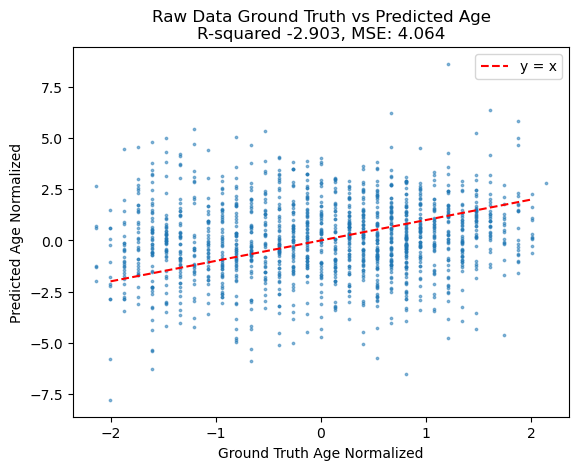

Raw Data PCA Components: MSE 4.06392, R-squared -2.90300


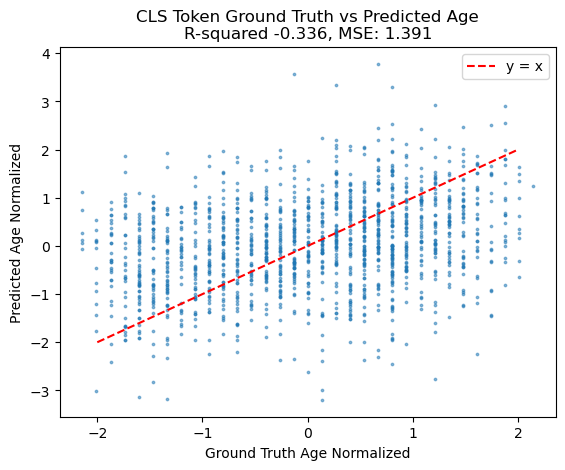

CLS Token PCA Components: MSE 1.39146, R-squared -0.33600


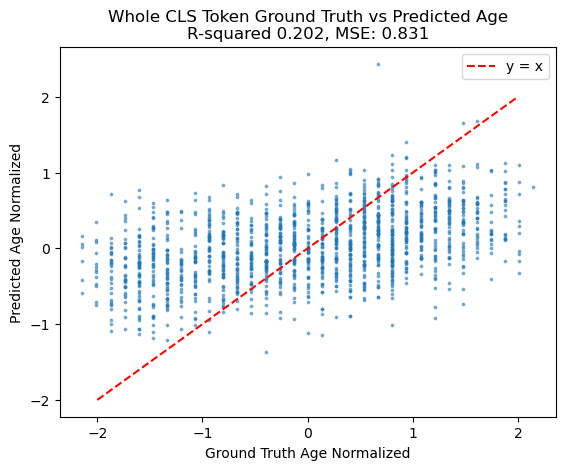

Whole CLS Token: MSE 0.83115, R-squared 0.20200


Loading cached shuffled indices for dataset at /home/sr2464/palmer_scratch/datasets/UKB_Large_rsfMRI_and_tffMRI_Arrow_WithRegression_v3_with_metadata/train_ukbiobank/cache-d8ca8d5320239fd9.arrow


Raw Data PCA Components: MSE 3.27768, R-squared -2.34800
CLS Token PCA Components: MSE 1.26952, R-squared -0.29700
Whole CLS Token: MSE 0.80019, R-squared 0.18300


Loading cached shuffled indices for dataset at /home/sr2464/palmer_scratch/datasets/UKB_Large_rsfMRI_and_tffMRI_Arrow_WithRegression_v3_with_metadata/train_ukbiobank/cache-d8ca8d5320239fd9.arrow


Raw Data PCA Components: MSE 4.15309, R-squared -3.06400
CLS Token PCA Components: MSE 1.44067, R-squared -0.41000
Whole CLS Token: MSE 0.88380, R-squared 0.13500


Loading cached shuffled indices for dataset at /home/sr2464/palmer_scratch/datasets/UKB_Large_rsfMRI_and_tffMRI_Arrow_WithRegression_v3_with_metadata/train_ukbiobank/cache-d8ca8d5320239fd9.arrow


Raw Data PCA Components: MSE 4.50155, R-squared -3.36600
CLS Token PCA Components: MSE 1.29651, R-squared -0.25700
Whole CLS Token: MSE 0.79449, R-squared 0.22900


Loading cached shuffled indices for dataset at /home/sr2464/palmer_scratch/datasets/UKB_Large_rsfMRI_and_tffMRI_Arrow_WithRegression_v3_with_metadata/train_ukbiobank/cache-d8ca8d5320239fd9.arrow


Raw Data PCA Components: MSE 4.55959, R-squared -3.47900
CLS Token PCA Components: MSE 1.37735, R-squared -0.35300
Whole CLS Token: MSE 0.82823, R-squared 0.18600


In [108]:
metadata_variable = "Age.At.MHQ"
for split_idx in range(5):
    verbose_flag = True if split_idx == 0 else False
    run_mlp_regression(variable_of_interest, verbose=verbose_flag, split=split_idx)

Loading cached shuffled indices for dataset at /home/sr2464/palmer_scratch/datasets/UKB_Large_rsfMRI_and_tffMRI_Arrow_WithRegression_v3_with_metadata/train_ukbiobank/cache-d8ca8d5320239fd9.arrow


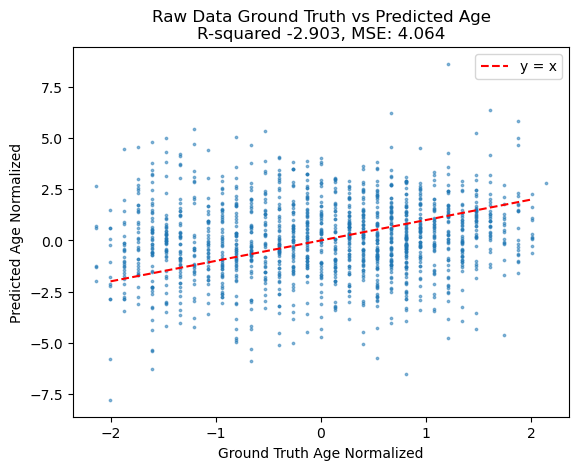

Raw Data PCA Components: MSE 4.06392, R-squared -2.90300


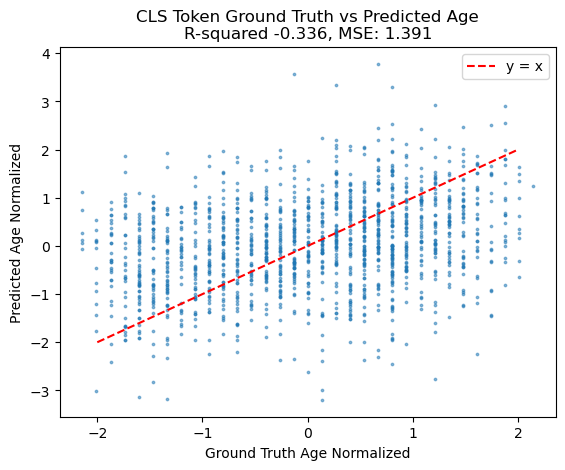

CLS Token PCA Components: MSE 1.39146, R-squared -0.33600


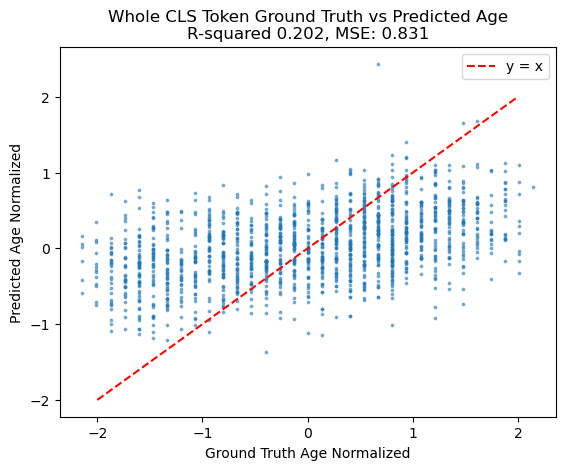

Whole CLS Token: MSE 0.83115, R-squared 0.20200


Loading cached shuffled indices for dataset at /home/sr2464/palmer_scratch/datasets/UKB_Large_rsfMRI_and_tffMRI_Arrow_WithRegression_v3_with_metadata/train_ukbiobank/cache-d8ca8d5320239fd9.arrow


Raw Data PCA Components: MSE 3.27768, R-squared -2.34800
CLS Token PCA Components: MSE 1.26952, R-squared -0.29700
Whole CLS Token: MSE 0.80019, R-squared 0.18300


Loading cached shuffled indices for dataset at /home/sr2464/palmer_scratch/datasets/UKB_Large_rsfMRI_and_tffMRI_Arrow_WithRegression_v3_with_metadata/train_ukbiobank/cache-d8ca8d5320239fd9.arrow


Raw Data PCA Components: MSE 4.15309, R-squared -3.06400
CLS Token PCA Components: MSE 1.44067, R-squared -0.41000
Whole CLS Token: MSE 0.88380, R-squared 0.13500


Loading cached shuffled indices for dataset at /home/sr2464/palmer_scratch/datasets/UKB_Large_rsfMRI_and_tffMRI_Arrow_WithRegression_v3_with_metadata/train_ukbiobank/cache-d8ca8d5320239fd9.arrow


Raw Data PCA Components: MSE 4.50155, R-squared -3.36600
CLS Token PCA Components: MSE 1.29651, R-squared -0.25700
Whole CLS Token: MSE 0.79449, R-squared 0.22900


Loading cached shuffled indices for dataset at /home/sr2464/palmer_scratch/datasets/UKB_Large_rsfMRI_and_tffMRI_Arrow_WithRegression_v3_with_metadata/train_ukbiobank/cache-d8ca8d5320239fd9.arrow


Raw Data PCA Components: MSE 4.55959, R-squared -3.47900
CLS Token PCA Components: MSE 1.37735, R-squared -0.35300
Whole CLS Token: MSE 0.82823, R-squared 0.18600


In [109]:
metadata_variable = "PHQ9.Severity"
for split_idx in range(5):
    verbose_flag = True if split_idx == 0 else False
    run_mlp_regression(variable_of_interest, verbose=verbose_flag, split=split_idx)

In [117]:
metadata_variable = "PHQ9.Severity"
verbose_flag = True if split_idx == 0 else False
phq9_results = run_mlp_regression(variable_of_interest, verbose=verbose_flag, split=split_idx)

Loading cached shuffled indices for dataset at /home/sr2464/palmer_scratch/datasets/UKB_Large_rsfMRI_and_tffMRI_Arrow_WithRegression_v3_with_metadata/train_ukbiobank/cache-d8ca8d5320239fd9.arrow


Raw Data PCA Components Scores: [-1.88713061 -1.86300245 -1.86414215 -1.75412418 -1.72282339]


/gpfs/gibbs/project/dijk/sr2464/conda_envs/brainlm/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


CLS Token PCA Component Scores: [-1.07998783 -1.64284795 -1.0767593  -1.04512635 -1.15641206]


/gpfs/gibbs/project/dijk/sr2464/conda_envs/brainlm/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/gpfs/gibbs/project/dijk/sr2464/conda_envs/brainlm/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/gpfs/gibbs/project/dijk/sr2464/conda_envs/brainlm/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Whole CLS Token Scores: [-0.77958283 -0.76073554 -0.77698249 -0.80452831 -0.80824985]


In [122]:
metadata_variable = "Age.At.MHQ"
verbose_flag = True if split_idx == 0 else False
phq9_results = run_mlp_regression(variable_of_interest, verbose=verbose_flag, split=split_idx)

Loading cached shuffled indices for dataset at /home/sr2464/palmer_scratch/datasets/UKB_Large_rsfMRI_and_tffMRI_Arrow_WithRegression_v3_with_metadata/train_ukbiobank/cache-d8ca8d5320239fd9.arrow
/gpfs/gibbs/project/dijk/sr2464/conda_envs/brainlm/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/gpfs/gibbs/project/dijk/sr2464/conda_envs/brainlm/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/gpfs/gibbs/project/dijk/sr2464/conda_envs/brainlm/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Raw Data PCA Components MSE: 1.753 +/- 0.026


/gpfs/gibbs/project/dijk/sr2464/conda_envs/brainlm/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/gpfs/gibbs/project/dijk/sr2464/conda_envs/brainlm/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


CLS Token PCA Component MSE: 1.111 +/- 0.066
Whole CLS Token MSE: 0.770 +/- 0.015


In [123]:
metadata_variable = "PHQ9.Severity"
verbose_flag = True if split_idx == 0 else False
phq9_results = run_mlp_regression(metadata_variable, verbose=verbose_flag, split=split_idx)

Loading cached shuffled indices for dataset at /home/sr2464/palmer_scratch/datasets/UKB_Large_rsfMRI_and_tffMRI_Arrow_WithRegression_v3_with_metadata/train_ukbiobank/cache-d8ca8d5320239fd9.arrow
/gpfs/gibbs/project/dijk/sr2464/conda_envs/brainlm/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/gpfs/gibbs/project/dijk/sr2464/conda_envs/brainlm/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/gpfs/gibbs/project/dijk/sr2464/conda_envs/brainlm/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/

Raw Data PCA Components MSE: 2.351 +/- 0.094


/gpfs/gibbs/project/dijk/sr2464/conda_envs/brainlm/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/gpfs/gibbs/project/dijk/sr2464/conda_envs/brainlm/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


CLS Token PCA Component MSE: 1.490 +/- 0.158


/gpfs/gibbs/project/dijk/sr2464/conda_envs/brainlm/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/gpfs/gibbs/project/dijk/sr2464/conda_envs/brainlm/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/gpfs/gibbs/project/dijk/sr2464/conda_envs/brainlm/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Whole CLS Token MSE: 1.004 +/- 0.061


/gpfs/gibbs/project/dijk/sr2464/conda_envs/brainlm/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [124]:
metadata_variable = "PCL.Score"
verbose_flag = True if split_idx == 0 else False
phq9_results = run_mlp_regression(metadata_variable, verbose=verbose_flag, split=split_idx)

Loading cached shuffled indices for dataset at /home/sr2464/palmer_scratch/datasets/UKB_Large_rsfMRI_and_tffMRI_Arrow_WithRegression_v3_with_metadata/train_ukbiobank/cache-d8ca8d5320239fd9.arrow


KeyboardInterrupt: 

In [ ]:
metadata_variable = "GAD7.Severity"
verbose_flag = True if split_idx == 0 else False
phq9_results = run_mlp_regression(metadata_variable, verbose=verbose_flag, split=split_idx)

## Run MLP Regressor on Age

In [22]:
variable_of_interest = "Age.At.MHQ"

In [23]:
# Select rows of concat_dataset where label is not nan
full_label_list = concat_ds[variable_of_interest]
non_nan_indices = [idx for idx in range(len(full_label_list)) if not math.isnan(full_label_list[idx])]
non_nan_ds = concat_ds.select(non_nan_indices)
non_nan_ds = non_nan_ds.shuffle(seed=42)
non_nan_ds

Loading cached shuffled indices for dataset at /home/sr2464/palmer_scratch/datasets/UKB_Large_rsfMRI_and_tffMRI_Arrow_WithRegression_v3_with_metadata/train_ukbiobank/cache-d8ca8d5320239fd9.arrow


Dataset({
    features: ['Raw_Recording', 'Voxelwise_RobustScaler_Normalized_Recording', 'Filename', 'Patient ID', 'Order', 'eid', 'Gender', 'Age.At.MHQ', 'PHQ9.Severity', 'Depressed.At.Baseline', 'Neuroticism', 'Self.Harm.Ever', 'Not.Worth.Living', 'PCL.Score', 'GAD7.Severity', 'cls_token_pca_components', 'whole_cls_token', 'recording_pca_components'],
    num_rows: 37156
})

In [25]:
raw_data_pca_nonnan = np.array(non_nan_ds["recording_pca_components"], dtype=np.float32)
print(raw_data_pca_nonnan.shape)
cls_token_pca_nonnan = np.array(non_nan_ds["cls_token_pca_components"], dtype=np.float32)
print(cls_token_pca_nonnan.shape)
whole_cls_token = np.array(non_nan_ds["whole_cls_token"], dtype=np.float32)
print(whole_cls_token.shape)

labels = non_nan_ds[variable_of_interest]
labels = [int(num) for num in labels]
labels[:10]

(37156, 200)
(37156, 200)
(37156, 512)


[67, 62, 70, 62, 52, 56, 61, 74, 72, 51]

In [69]:
z_score_transform = StandardScaler()
labels_normalized_np = z_score_transform.fit_transform(np.expand_dims(np.array(labels), axis=1))
labels_normalized_np = np.squeeze(labels_normalized_np, axis=1)
labels_normalized = labels_normalized_np.tolist()
labels_normalized[:10]

[0.5399152915688842,
 -0.13684576249933705,
 0.9459719240098169,
 -0.13684576249933705,
 -1.4903678706357795,
 -0.9489590273812025,
 -0.2721979733129813,
 1.487380767264394,
 1.2166763456371055,
 -1.6257200814494237]

In [86]:
# Run on raw data
split_idx = int(raw_data_pca_nonnan.shape[0] * 0.8)
train_X_raw_data = raw_data_pca_nonnan[:split_idx]
test_X_raw_data = raw_data_pca_nonnan[split_idx:]
print(train_X_raw_data.shape)
print(test_X_raw_data.shape)
train_y_raw_data = labels_normalized[:split_idx]
test_y_raw_data = labels_normalized[split_idx:]

(29724, 200)
(7432, 200)


In [87]:
regr = MLPRegressor(random_state=1234, max_iter=500, hidden_layer_sizes=[100], 
                   learning_rate_init=0.001, verbose=True)
regr.fit(train_X_raw_data, train_y_raw_data)
predictions = regr.predict(test_X_raw_data)
print(predictions.shape)
print(predictions[:10])
print(test_y_raw_data[:10])

Iteration 1, loss = 6.43311614
Iteration 2, loss = 2.00980594
Iteration 3, loss = 1.07529799
Iteration 4, loss = 0.71784580
Iteration 5, loss = 0.55765426
Iteration 6, loss = 0.47752955
Iteration 7, loss = 0.43441098
Iteration 8, loss = 0.40947573
Iteration 9, loss = 0.39421895
Iteration 10, loss = 0.38207205
Iteration 11, loss = 0.37433663
Iteration 12, loss = 0.36490753
Iteration 13, loss = 0.35921475
Iteration 14, loss = 0.35116701
Iteration 15, loss = 0.34466497
Iteration 16, loss = 0.33820707
Iteration 17, loss = 0.33021714
Iteration 18, loss = 0.32446353
Iteration 19, loss = 0.31871545
Iteration 20, loss = 0.31154116
Iteration 21, loss = 0.30580534
Iteration 22, loss = 0.29951130
Iteration 23, loss = 0.29220685
Iteration 24, loss = 0.28858798
Iteration 25, loss = 0.28309584
Iteration 26, loss = 0.27697022
Iteration 27, loss = 0.27207040
Iteration 28, loss = 0.26524893
Iteration 29, loss = 0.26079607
Iteration 30, loss = 0.25647368
Iteration 31, loss = 0.25064810
Iteration 32, los

In [88]:
r2_score = round(regr.score(test_X_raw_data, test_y_raw_data), 3)
r2_score

-0.836

In [89]:
mse_criterion = nn.MSELoss()
mse_loss = mse_criterion(torch.tensor(predictions, dtype=torch.float32), torch.tensor(test_y_raw_data, dtype=torch.float32))
mse_loss

tensor(1.7970)

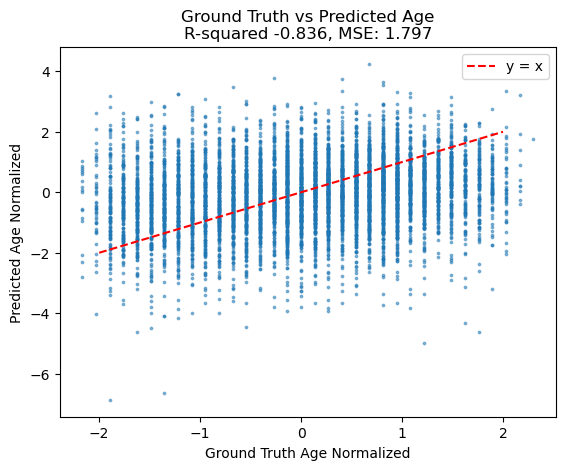

In [90]:
plt.scatter(test_y_cls_token, predictions, s=3, alpha=0.5)
plt.plot([-2.0, 2.0], [-2.0, 2.0], label="y = x", color="red", linestyle="--")
plt.title(f"Ground Truth vs Predicted Age\nR-squared {r2_score:.3f}, MSE: {mse_loss:.3f}")
plt.xlabel("Ground Truth Age Normalized")
plt.ylabel("Predicted Age Normalized")
plt.legend()
plt.show()
plt.close()

In [91]:
# Run on CLS tokens
split_idx = int(cls_token_pca_nonnan.shape[0] * 0.8)
train_X_cls_token = cls_token_pca_nonnan[:split_idx]
test_X_cls_token = cls_token_pca_nonnan[split_idx:]
print(train_X_cls_token.shape)
print(test_X_cls_token.shape)
train_y_cls_token = labels_normalized[:split_idx]
test_y_cls_token = labels_normalized[split_idx:]

(29724, 200)
(7432, 200)


In [92]:
regr = MLPRegressor(random_state=1234, max_iter=500, hidden_layer_sizes=[100], 
                   learning_rate_init=0.001, verbose=True)
regr.fit(train_X_cls_token, train_y_cls_token)
predictions = regr.predict(test_X_cls_token)
print(predictions.shape)
print(predictions[:10])
print(test_y_cls_token[:10])

Iteration 1, loss = 0.41876408
Iteration 2, loss = 0.38541800
Iteration 3, loss = 0.37629165
Iteration 4, loss = 0.37005533
Iteration 5, loss = 0.36603253
Iteration 6, loss = 0.36164508
Iteration 7, loss = 0.35899852
Iteration 8, loss = 0.35514668
Iteration 9, loss = 0.35221883
Iteration 10, loss = 0.34829682
Iteration 11, loss = 0.34582645
Iteration 12, loss = 0.34207273
Iteration 13, loss = 0.33970126
Iteration 14, loss = 0.33546520
Iteration 15, loss = 0.33219292
Iteration 16, loss = 0.32972531
Iteration 17, loss = 0.32621933
Iteration 18, loss = 0.32388617
Iteration 19, loss = 0.32020440
Iteration 20, loss = 0.31749646
Iteration 21, loss = 0.31453591
Iteration 22, loss = 0.31208137
Iteration 23, loss = 0.30939805
Iteration 24, loss = 0.30673341
Iteration 25, loss = 0.30375065
Iteration 26, loss = 0.30172532
Iteration 27, loss = 0.29881078
Iteration 28, loss = 0.29721489
Iteration 29, loss = 0.29349609
Iteration 30, loss = 0.29146913
Iteration 31, loss = 0.28910114
Iteration 32, los

In [93]:
r2_score = round(regr.score(test_X_cls_token, test_y_cls_token), 3)
r2_score

-0.097

In [94]:
mse_criterion = nn.MSELoss()
mse_loss = mse_criterion(torch.tensor(predictions, dtype=torch.float32), torch.tensor(test_y_cls_token, dtype=torch.float32))
mse_loss

tensor(1.0739)

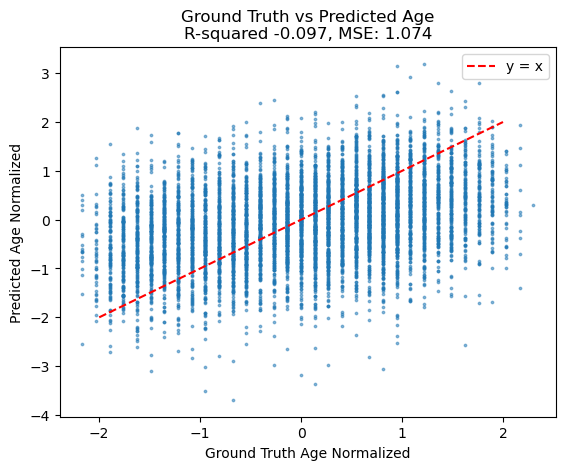

In [95]:
plt.scatter(test_y_cls_token, predictions, s=3, alpha=0.5)
plt.plot([-2.0, 2.0], [-2.0, 2.0], label="y = x", color="red", linestyle="--")
plt.title(f"Ground Truth vs Predicted Age\nR-squared {r2_score:.3f}, MSE: {mse_loss:.3f}")
plt.xlabel("Ground Truth Age Normalized")
plt.ylabel("Predicted Age Normalized")
plt.legend()
plt.show()
plt.close()

In [78]:
# Run on whole CLS tokens
split_idx = int(whole_cls_token.shape[0] * 0.8)
train_X_cls_token = whole_cls_token[:split_idx]
test_X_cls_token = whole_cls_token[split_idx:]
print(train_X_cls_token.shape)
print(test_X_cls_token.shape)
train_y_cls_token = labels_normalized[:split_idx]
test_y_cls_token = labels_normalized[split_idx:]

(29724, 512)
(7432, 512)


In [79]:
regr = MLPRegressor(random_state=1234, max_iter=500, hidden_layer_sizes=[100], 
                   learning_rate_init=0.001, verbose=True)
regr.fit(train_X_cls_token, train_y_cls_token)
predictions = regr.predict(test_X_cls_token)
print(predictions.shape)
print(predictions[:10])
print(test_y_cls_token[:10])

Iteration 1, loss = 0.50959783
Iteration 2, loss = 0.44106929
Iteration 3, loss = 0.43274921
Iteration 4, loss = 0.42827629
Iteration 5, loss = 0.42478915
Iteration 6, loss = 0.41896849
Iteration 7, loss = 0.41787743
Iteration 8, loss = 0.41407479
Iteration 9, loss = 0.41517306
Iteration 10, loss = 0.41585376
Iteration 11, loss = 0.41477689
Iteration 12, loss = 0.41435860
Iteration 13, loss = 0.42042562
Iteration 14, loss = 0.41511123
Iteration 15, loss = 0.41474360
Iteration 16, loss = 0.40958523
Iteration 17, loss = 0.41085874
Iteration 18, loss = 0.40668684
Iteration 19, loss = 0.40526428
Iteration 20, loss = 0.40548494
Iteration 21, loss = 0.40420244
Iteration 22, loss = 0.41072987
Iteration 23, loss = 0.40352489
Iteration 24, loss = 0.40251821
Iteration 25, loss = 0.40487083
Iteration 26, loss = 0.40434296
Iteration 27, loss = 0.40230840
Iteration 28, loss = 0.40220552
Iteration 29, loss = 0.40286700
Iteration 30, loss = 0.39909877
Iteration 31, loss = 0.39867084
Iteration 32, los

In [80]:
r2_score = round(regr.score(test_X_cls_token, test_y_cls_token), 3)
r2_score

0.239

In [83]:
mse_criterion = nn.MSELoss()
mse_loss = mse_criterion(torch.tensor(predictions, dtype=torch.float32), torch.tensor(test_y_cls_token, dtype=torch.float32))
mse_loss

tensor(0.7450)

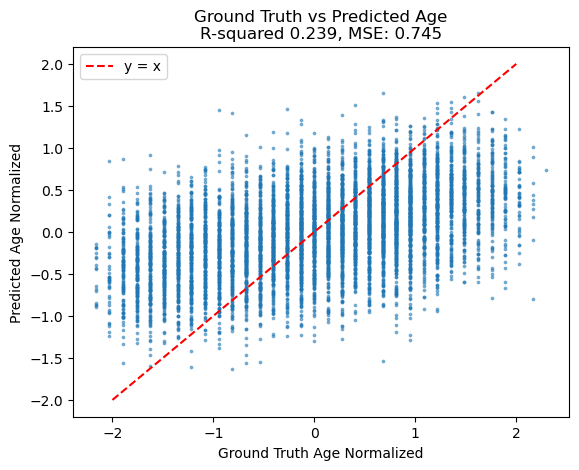

In [85]:
plt.scatter(test_y_cls_token, predictions, s=3, alpha=0.5)
plt.plot([-2.0, 2.0], [-2.0, 2.0], label="y = x", color="red", linestyle="--")
plt.title(f"Ground Truth vs Predicted Age\nR-squared {r2_score:.3f}, MSE: {mse_loss:.3f}")
plt.xlabel("Ground Truth Age Normalized")
plt.ylabel("Predicted Age Normalized")
plt.legend()
plt.show()
plt.close()